In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans

In [2]:
# === STEP 1: Load the Data ===
# Replace with your actual file paths
myc_file = "/Users/nakku/Downloads/GSM2579597_Myc_rawdata.txt"
max_file = "/Users/nakku/Downloads/GSM2579596_Max_rawdata.txt"

# Load tab-delimited files
myc_df = pd.read_csv(myc_file, sep="\t")
max_df = pd.read_csv(max_file, sep="\t")

# Rename the Alexa488 columns for clarity
myc_df = myc_df.rename(columns={"Alexa488": "Alexa488_Myc"})
max_df = max_df.rename(columns={"Alexa488": "Alexa488_Max"})

In [3]:
# === STEP 2: Merge on DNA Sequence ===
merged_df = pd.merge(myc_df, max_df, on="Sequence", suffixes=("_Myc", "_Max"))

# === STEP 3: Compute log2 Fold Change ===
merged_df["log2FC_Myc_vs_Max"] = np.log2(merged_df["Alexa488_Myc"] + 1) - np.log2(merged_df["Alexa488_Max"] + 1)

# === STEP 4: Identify Enriched Sequences ===
merged_df["Myc_enriched"] = merged_df["log2FC_Myc_vs_Max"] > 1
merged_df["Max_enriched"] = merged_df["log2FC_Myc_vs_Max"] < -1



In [4]:
# === STEP 5: Save Top Enriched Sequences ===
top_myc = merged_df.sort_values("log2FC_Myc_vs_Max", ascending=False).head(100)
top_max = merged_df.sort_values("log2FC_Myc_vs_Max", ascending=True).head(100)

top_myc[["Sequence", "log2FC_Myc_vs_Max"]].to_csv("top_100_myc_enriched.txt", sep="\t", index=False)
top_max[["Sequence", "log2FC_Myc_vs_Max"]].to_csv("top_100_max_enriched.txt", sep="\t", index=False)


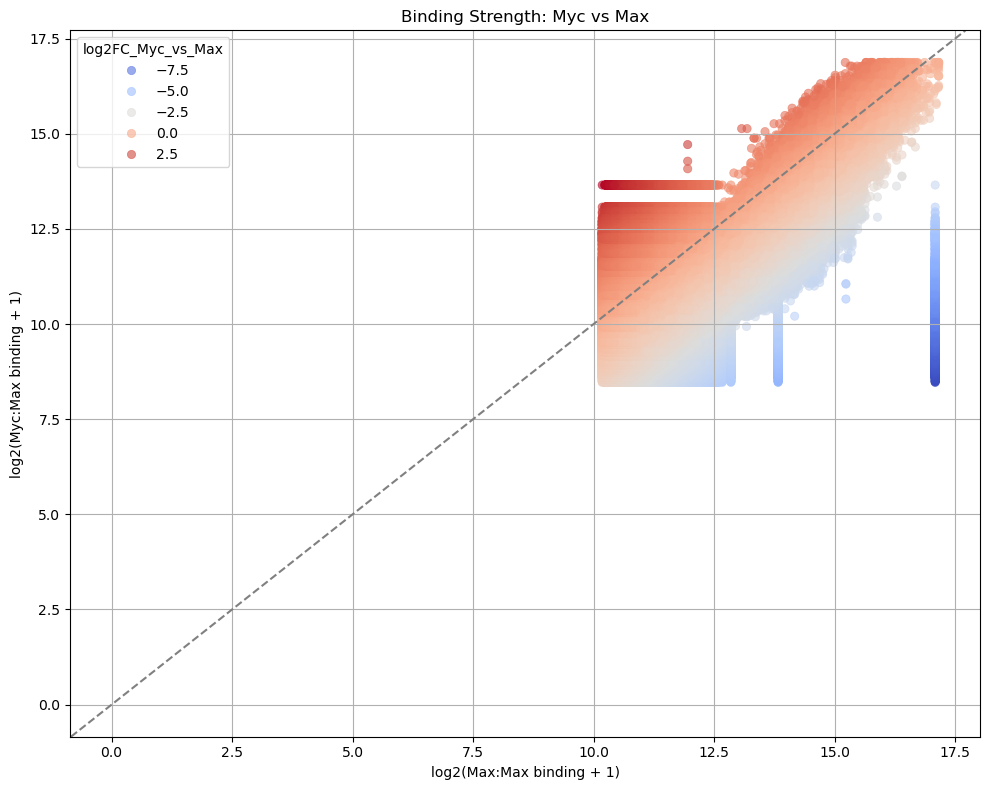

In [5]:
# === STEP 6: Scatter Plot ===
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=np.log2(merged_df["Alexa488_Max"] + 1),
    y=np.log2(merged_df["Alexa488_Myc"] + 1),
    hue=merged_df["log2FC_Myc_vs_Max"],
    palette="coolwarm",
    edgecolor=None,
    alpha=0.6
)
plt.title("Binding Strength: Myc vs Max")
plt.xlabel("log2(Max:Max binding + 1)")
plt.ylabel("log2(Myc:Max binding + 1)")
plt.axline((0, 0), slope=1, color='gray', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.savefig("myc_vs_max_binding_scatter.png", dpi=300)
plt.show()


## 2.  K-means Clustering

In [7]:
X = merged_df[["Alexa488_Myc", "Alexa488_Max"]].copy()
X = np.log2(X + 1)  # log transform to stabilize variance

In [8]:
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)
merged_df["cluster"] = clusters

/opt/anaconda3/envs/mmgbsa_ml/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


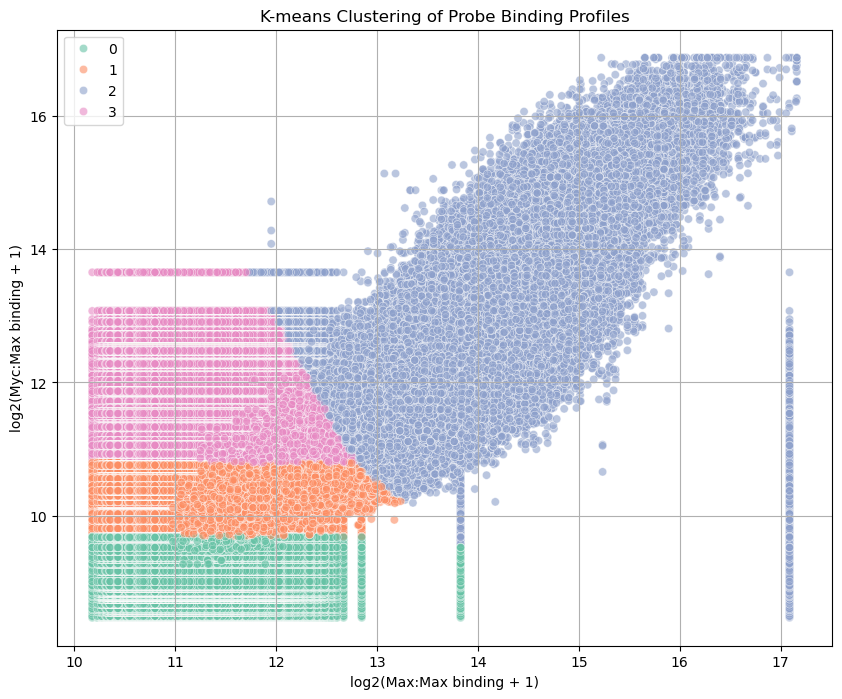

In [9]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=X["Alexa488_Max"], y=X["Alexa488_Myc"],
    hue=clusters, palette="Set2", alpha=0.6
)
plt.xlabel("log2(Max:Max binding + 1)")
plt.ylabel("log2(Myc:Max binding + 1)")
plt.title("K-means Clustering of Probe Binding Profiles")
plt.grid(True)
plt.show()

In [10]:
myc_only = merged_df[merged_df["cluster"] == 2]
#sns.clustermap(X, cmap="viridis")

In [12]:
merged_df["cluster"].value_counts()


0    10860119
1     9320199
3     3446568
2      550682
Name: cluster, dtype: int64

In [13]:
for i in range(4):
    subset = merged_df[merged_df["cluster"] == i]
    print(f"Cluster {i}: Mean Myc = {subset['Alexa488_Myc'].mean():.2f}, Mean Max = {subset['Alexa488_Max'].mean():.2f}")


Cluster 0: Mean Myc = 580.12, Mean Max = 2235.74
Cluster 1: Mean Myc = 1214.50, Mean Max = 2241.92
Cluster 2: Mean Myc = 7524.65, Mean Max = 16266.00
Cluster 3: Mean Myc = 2862.90, Mean Max = 2246.07


In [14]:
cluster2_myc_pref = merged_df[merged_df["cluster"] == 2][["Sequence", "Alexa488_Myc", "Alexa488_Max"]]
cluster3_max_pref = merged_df[merged_df["cluster"] == 3][["Sequence", "Alexa488_Myc", "Alexa488_Max"]]


In [15]:
sns.kdeplot(
    data=merged_df, 
    x="log2_Max", y="log2_Myc",
    hue="cluster", fill=True, common_norm=False, alpha=0.3
)


ValueError: Could not interpret value `log2_Max` for `x`. An entry with this name does not appear in `data`.

In [16]:
print(merged_df.columns)


Index(['Column_Myc', 'Row_Myc', 'Name_Myc', 'ID_Myc', 'Sequence',
       'Alexa488_Myc', 'Column_Max', 'Row_Max', 'Name_Max', 'ID_Max',
       'Alexa488_Max', 'log2FC_Myc_vs_Max', 'Myc_enriched', 'Max_enriched',
       'cluster'],
      dtype='object')
